In [1]:
%matplotlib inline

import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim
seed = cfg_seed
env_str=cfg_env
# num_iter_max=200000
env_name = 'CustomPendulum-v0'
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter3_"

loss_list = []
normalized_loss_list = []
print("seed",seed)

print(datetime.datetime.now())

seed 2
2023-07-06 11:39:22.228202


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)

2 1 1


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/proxima-hishinuma/anaconda3/

In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_weightedvae2_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_pendulum_bamdp_weightedvae2_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

# iwvi.load_base(ckpt_key="unweighted")
iwvi.load(ckpt_key="policy_optimization_iter2")

dec: h_dim 48
iwvi load ckpt1, ckpt2 ckpt_iwvi_basepartpendulum_policy_optimization_iter2 ckpt_iwvi_pendulum_policy_optimization_iter2
base load ckpt ckpt_basevi_pendulum_policy_optimization_iter2
base load self.initial_belief.data.sum() tensor(-3.9333)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(-3.8191)
penalty_target_min tensor(-6.1621) penalty_target_max tensor(88.4236)
train_loss:  -5.239171002960205
valid_loss:  -2.3409641975402833
h_min_tilde -6.1621227 ell_tilde -4.6595296418762215 kappa_tilde 0.0008157917464170256
success load ckpt_iwvi_basepartpendulum_policy_optimization_iter2
train_loss:  -0.9168302686601878
valid_loss:  -0.35208348701000214
weight_alpha 1.0 h_min_tilde -6.1621227 ell_tilde -0.8038809123301508 kappa_tilde 0.0004320050717009444


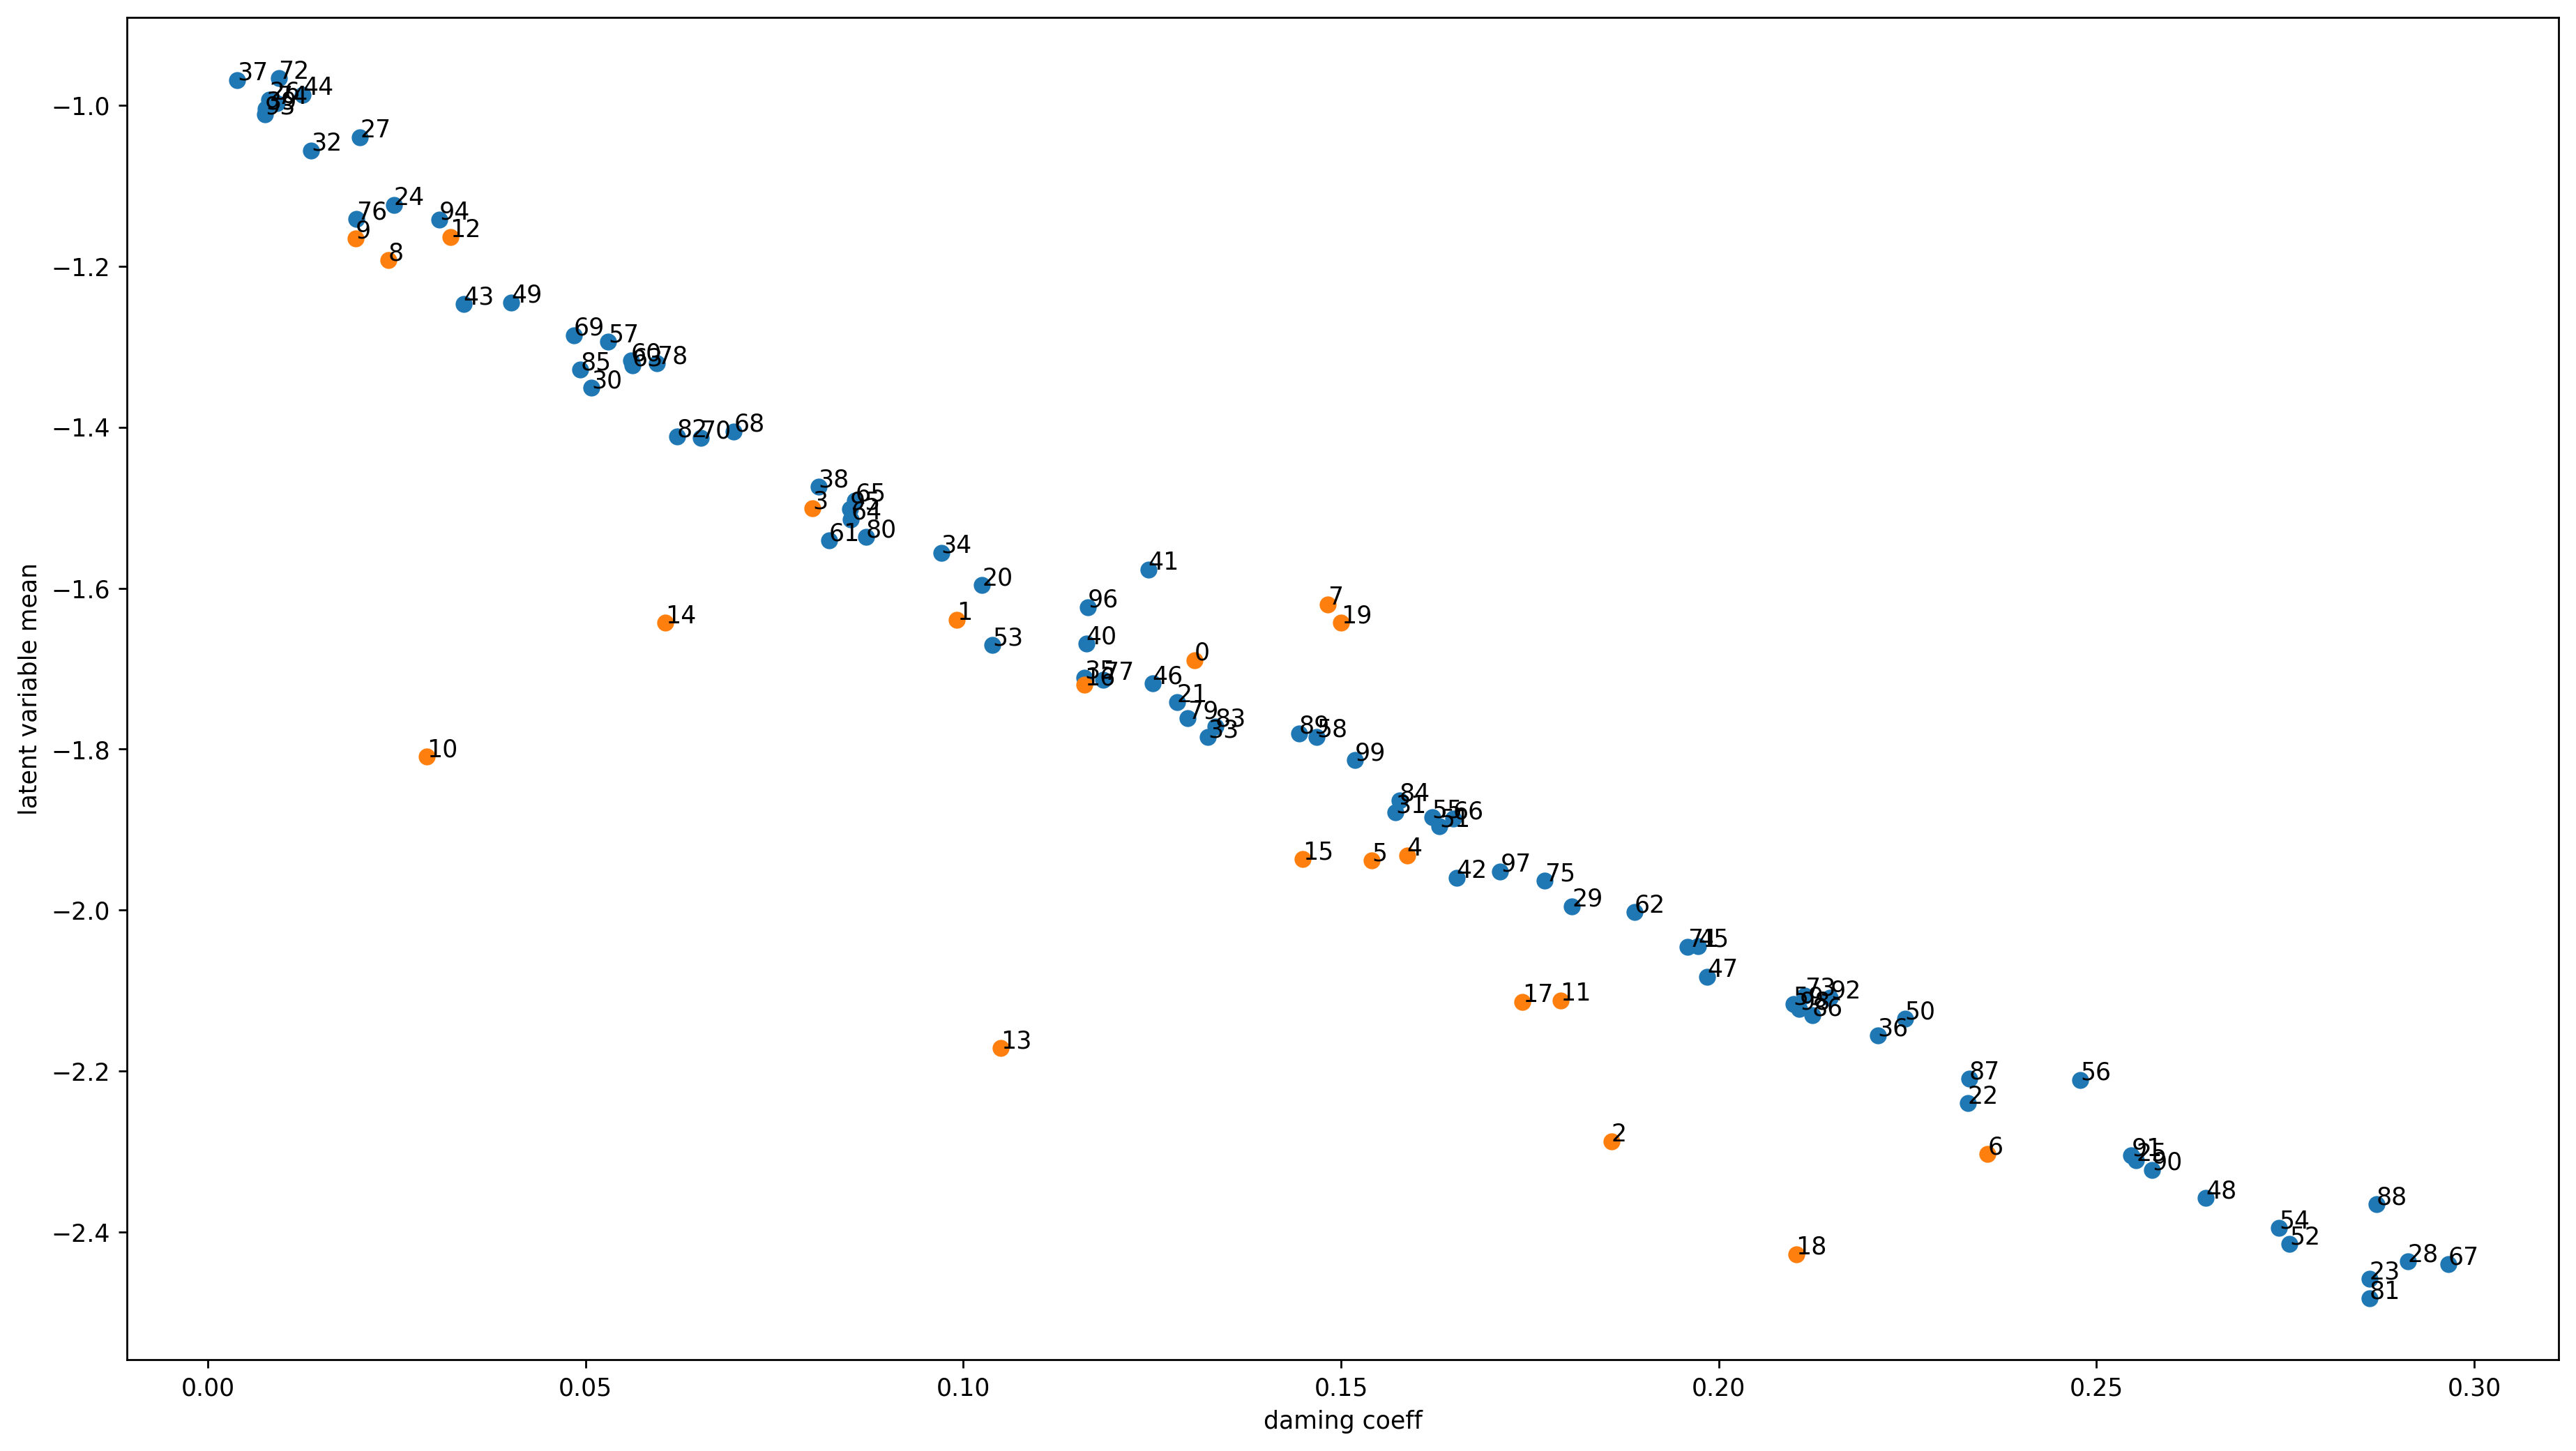

[0.13059672 0.09910045 0.18578129 0.08004818 0.15874263 0.15407344
 0.23560054 0.14827105 0.02389364 0.01958595]
[0.02895927 0.17902359 0.03208371 0.10494789 0.06052297 0.14492095
 0.1160678  0.17400125 0.2102257  0.15000251]
[0.1024841  0.12826379 0.23296776 0.28612267 0.02462848 0.25525515
 0.00816071 0.02014331 0.29117409 0.18054514]
[0.05076763 0.15722006 0.01370369 0.13240648 0.0970624  0.11606697
 0.22102412 0.0039052  0.08081664 0.00766528]
[0.11625703 0.12447175 0.16529337 0.03383286 0.01253931 0.19725372
 0.12502603 0.1984444  0.26449567 0.04018626]
[0.22463336 0.16300357 0.27553759 0.10387137 0.27417464 0.16205745
 0.24787495 0.05301365 0.14677985 0.20985619]
[0.05598814 0.08221778 0.18880792 0.05618596 0.08512674 0.08568112
 0.16484905 0.29655291 0.06963548 0.04843997]
[0.06522073 0.19590615 0.00937427 0.21138825 0.00917684 0.1769346
 0.0196991  0.11854523 0.05940813 0.12971673]
[0.08712802 0.28609799 0.06211495 0.13337228 0.15771997 0.04932573
 0.21239135 0.2331309  0.28702

In [5]:
plt.figure(figsize=(18,10), dpi=250)
np_mulogvar = iwvi.mulogvar_offlinedata.numpy()
plt.xlabel("daming coeff")
plt.ylabel("latent variable mean")

plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
# plt.xlim([-0.05,0.35])
for i in range(len(debug_info)):
    plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.png")
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.eps")
# plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.pdf")
plt.show()


for i in range(10):
    print(debug_info[i*10 : (i+1)*10,1])
# plt.show()
print("摩擦係数-潜在変数")

In [6]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 7.152557373046875e-07


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observ


 1 3.2599937915802

 2 3.2064309120178223

 3 3.4292168617248535

 4 3.3744685649871826

 5 3.2622010707855225

 6 3.3272602558135986

 7 3.5806357860565186

 8 3.4235475063323975

 9 3.234808921813965

 10 3.2377994060516357

 11 3.2168796062469482

 12 3.3909034729003906

 13 3.1271681785583496

 14 3.4538357257843018

 15 3.2225286960601807

 16 3.411620616912842

 17 3.3605449199676514

 18 3.386239528656006

 19 3.390641927719116

 20 3.25274395942688

 21 3.2327380180358887

 22 3.321181058883667

 23 3.580240249633789

 24 3.477431058883667

 25 3.198866128921509

 26 3.30700945854187

 27 3.2078070640563965

 28 3.275970697402954

 29 3.7165427207946777

 30 3.378021717071533

 31 3.1484391689300537

 32 3.194894313812256

 33 3.2411770820617676

 34 3.196842670440674

 35 3.3113112449645996

 36 3.220571756362915

 37 3.445301055908203

 38 3.239885091781616

 39 3.315535068511963

 40 3.1789326667785645

 41 3.3064873218536377

 42 3.3607780933380127

 43 3.2938334941864014


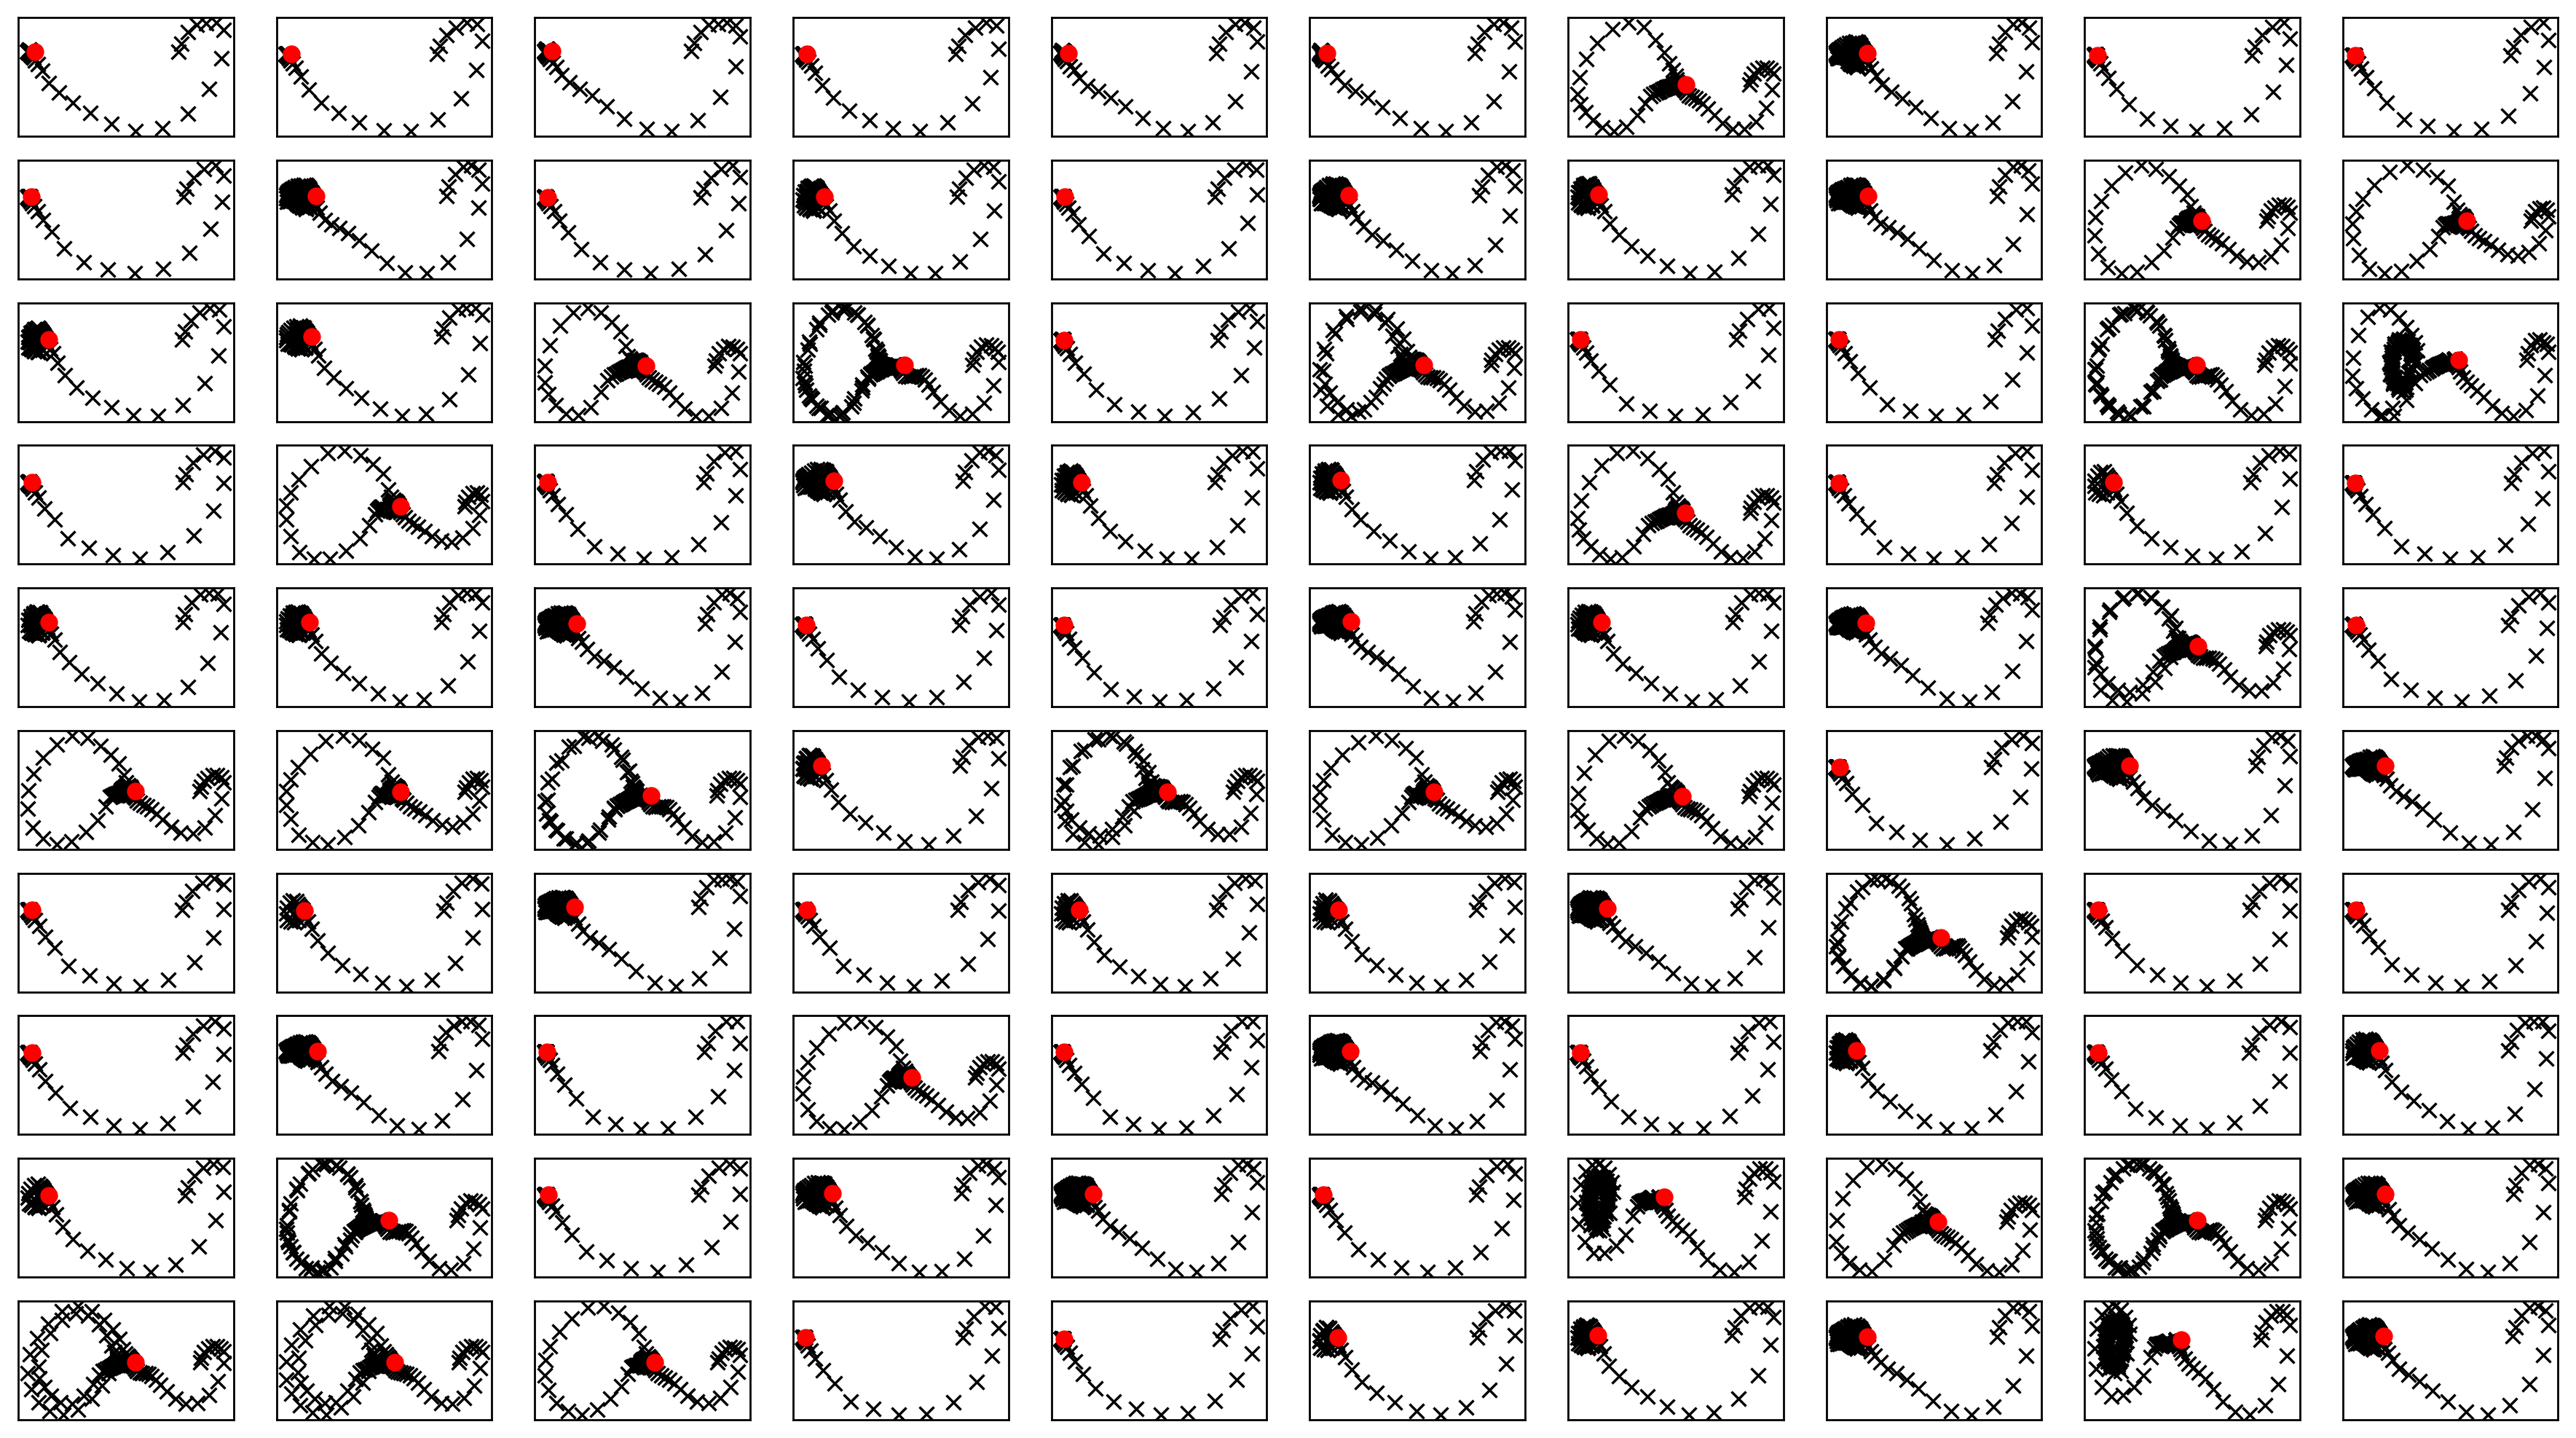

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx") 
    ax_list[-1].plot(0, 0,"ro")
plt.show()

In [ ]:
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)


 0 4.76837158203125e-07

 1 3.2168116569519043

 2 3.3402583599090576

 3 3.3261072635650635

 4 3.260010004043579

 5 3.4521384239196777

 6 3.4028663635253906

 7 3.332030773162842

 8 3.3323912620544434

 9 3.2309348583221436

 10 3.378021478652954

 11 3.2743022441864014

 12 3.285367727279663

 13 3.303858995437622

 14 3.2762715816497803

 15 3.3072848320007324

 16 3.402977466583252

 17 3.3664021492004395

 18 3.2347519397735596

 19 3.3847620487213135

 20 3.2591030597686768

 21 3.3452203273773193

 22 3.5073232650756836

 23 3.313648223876953

 24 3.4723198413848877

 25 3.2742016315460205

 26 3.373368740081787

 27 3.398650884628296

 28 3.340745449066162

 29 3.415029525756836

 30 3.277498245239258

 31 3.417513132095337

 32 3.4127399921417236

 33 3.4884583950042725

 34 3.3871989250183105

 35 3.3147482872009277

 36 3.362708330154419

 37 3.308345079421997

 38 3.3539702892303467

 39 3.4298384189605713

 40 3.3864729404449463

 41 3.4382123947143555

 42 3.51965093

In [ ]:

fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1],"kx") 
#     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"o") 
    ax_list[-1].plot(simdata0a[i][:,0], simdata0a[i][:,1]) 
    ax_list[-1].plot(simdata0b[i][:,0], simdata0b[i][:,1]) 
#     ax_list[-1].plot(simdata0c[i][:,0], simdata0c[i][:,1]) 

    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro")
plt.savefig(figfilenamehead+"iter0.png")
# plt.savefig(figfilenamehead+"iter0.pdf")
plt.savefig(figfilenamehead+"iter0.eps")
print("実環境方策rollout vs Sim環境方策rollout")

In [ ]:
print(datetime.datetime.now())